In [64]:
import keras
import pandas as pd
from keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
import numpy as np
import os

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, InputLayer, LSTM, Dropout, Bidirectional

# from keras import ops
import numpy as np

In [66]:
test = pd.read_csv(r'C:\Users\cptsc\OneDrive\Desktop\ComputerScience\FYP\lstm_forecasting\second_deployment\test.csv')
train = pd.read_csv(r'C:\Users\cptsc\OneDrive\Desktop\ComputerScience\FYP\lstm_forecasting\second_deployment\train.csv')

In [67]:
print(test.head())
print(train.head())

             timestamp          lux  irradiance  \
0  2025-04-10_14-38-00  40817.81250  340.148438   
1  2025-04-10_14-39-00  40943.59375  341.196615   
2  2025-04-10_14-40-00  40922.03125  341.016927   
3  2025-04-10_14-41-00  40914.84375  340.957031   
4  2025-04-10_14-42-00  40889.68750  340.747396   

                            nir_image_path  temperature   humidity  \
0  /photos_nir/2025-04-10_14-38-00_nir.jpg    30.009537  51.747768   
1  /photos_nir/2025-04-10_14-39-00_nir.jpg    30.412757  46.620737   
2  /photos_nir/2025-04-10_14-40-00_nir.jpg    30.404746  45.775769   
3  /photos_nir/2025-04-10_14-41-00_nir.jpg    30.450141  48.066529   
4  /photos_nir/2025-04-10_14-42-00_nir.jpg    30.602350  52.886473   

                            rgb_image_path  
0  /photos_rgb/2025-04-10_14-38-00_rgb.jpg  
1  /photos_rgb/2025-04-10_14-39-00_rgb.jpg  
2  /photos_rgb/2025-04-10_14-40-00_rgb.jpg  
3  /photos_rgb/2025-04-10_14-41-00_rgb.jpg  
4  /photos_rgb/2025-04-10_14-42-00_rgb.jpg  
  

#### Clean the data so it can be used 

In [68]:
train = train.drop(columns=['timestamp'])
test = test.drop(columns=['timestamp'])

train = train.drop(columns=['lux'])
test = test.drop(columns=['lux'])

train = train.drop(columns=['nir_image_path'])
test = test.drop(columns=['nir_image_path'])

train = train.drop(columns=['rgb_image_path'])
test = test.drop(columns=['rgb_image_path'])

In [69]:
print(train.head())
print("\n")
print(test.head())

   irradiance  temperature   humidity
0  360.483073    26.431296  50.176089
1  358.850911    27.026780  52.653773
2  358.236979    27.592889  43.172198
3  354.298828    27.750439  46.204929
4  347.560547    27.331197  42.828870


   irradiance  temperature   humidity
0  340.148438    30.009537  51.747768
1  341.196615    30.412757  46.620737
2  341.016927    30.404746  45.775769
3  340.957031    30.450141  48.066529
4  340.747396    30.602350  52.886473


In [70]:
average_temp = test['temperature'].mean()
print("Average Temperature:", average_temp)

Average Temperature: 12.80109002444904


In [71]:
average_irradiation = test['irradiance'].mean()
print("Average Irradiation:", average_irradiation)

Average Irradiation: 120.36161965961062


In [72]:
LEARNING_RATE = 0.001
RANDOM_STATE = 44
BATCH_SIZE = 1024

In [73]:
def fix_randomness():
    tf.random.set_seed(RANDOM_STATE)

    from numpy.random import seed
    seed(RANDOM_STATE)
    keras.utils.set_random_seed(RANDOM_STATE)

fix_randomness()

MULTIVARIATE

In [74]:
EPOCHS = 500
MULTIV_TRAINING_WINDOW = 30
lead_time = 10

In [75]:
# Creating the model input for multivariate forecasting
def df_to_model_input2(df_np, col_index, window_size):
    df_np = df_np.to_numpy()
    x = []
    y = []

    for i in range(len(df_np) - window_size - lead_time):
        row = [r for r in df_np[i:i+window_size]]
        x.append(row)

        label = df_np[i+lead_time+window_size][col_index]
        y.append(label)

    return np.array(x), np.array(y)

In [76]:
multiv_path = 'models/second_deployment.keras'

In [77]:
NUMBER_OF_FEATURES = len(train.columns)

In [78]:
scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
test = pd.DataFrame(scaler.transform(test), columns=test.columns)

In [79]:
def get_train_test_val(x, y):
    ds_len = len(y)
    train_len = int(0.8*ds_len)
    
    return x[:train_len], y[:train_len], x[train_len:], y[train_len:]

In [80]:
target_col_index = train.columns.get_loc("irradiance")
x, y = df_to_model_input2(train, target_col_index, MULTIV_TRAINING_WINDOW)

x_train, y_train, x_val, y_val = get_train_test_val(x, y)
x_test, y_test = df_to_model_input2(test, target_col_index, MULTIV_TRAINING_WINDOW)

In [81]:
x_test.shape,  y_test.shape

((1393, 30, 3), (1393,))

In [ ]:
# Loads a trained model, makes predictions on scaled test data, unscales both predictions and true values,
# and computes Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) on the unscaled data.

def unscale_and_evaluate(scaler, model_path, target_column_index=-1):
    
    # Load the model
    model = load_model(model_path)

    # Make predictions on the scaled test set
    y_pred_scaled = model.predict(x_test)

    # Create dummy arrays to match the scaler's expected input shape
    dummy_data_pred = np.zeros((y_pred_scaled.shape[0], NUMBER_OF_FEATURES))
    dummy_data_test = np.zeros((y_test.shape[0], NUMBER_OF_FEATURES))

    # Insert the predicted values and y_test into the correct column
    dummy_data_pred[:, target_column_index] = y_pred_scaled[:, 0]
    dummy_data_test[:, target_column_index] = y_test[:] # it kept that way to be able to modify if needed

    # Perform inverse transform to get the unscaled predictions and y_test
    unscaled_predictions = scaler.inverse_transform(dummy_data_pred)[:, target_column_index]
    y_test_unscaled = scaler.inverse_transform(dummy_data_test)[:, target_column_index]

    # Calculate RMSE
    mse = mean_squared_error(y_test_unscaled, unscaled_predictions)
    rmse = np.sqrt(mse)

    print(f"Mean Squared Error (Unscaled): {mse}")
    print(f"Root Mean Squared Error (Unscaled): {rmse}")

    return mse, rmse

In [84]:
model_lstm_param, model_dense_params = 512, 8

In [85]:
def run_multiv():

    # Create the model
    model = Sequential()
    model.add(InputLayer((MULTIV_TRAINING_WINDOW, NUMBER_OF_FEATURES)))
    model.add(LSTM(model_lstm_param))
    model.add(Dropout(0.5))
    model.add(Dense(model_dense_params, 'relu'))
    model.add(Dense(1, 'linear'))

    # Model checkpoint
    model_file = multiv_path

    cp = ModelCheckpoint(model_file, save_best_only=True)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=5,                 # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True   # Restore the weights of the best epoch after stopping
    )

    # Compile the model
    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics=[MeanSquaredError()]
    )
   
    # Train the model
    model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[cp, early_stopping]
    )

run_multiv()

model = load_model(multiv_path)
print("Model Validation RMSE") 
model.evaluate(x_test, y_test)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 873ms/step - loss: 0.0996 - mean_squared_error: 0.0955 - val_loss: 0.0547 - val_mean_squared_error: 0.0547
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - loss: 0.0307 - mean_squared_error: 0.0297 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 724ms/step - loss: 0.0121 - mean_squared_error: 0.0116 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 738ms/step - loss: 0.0083 - mean_squared_error: 0.0082 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step - loss: 0.0046 - mean_squared_error: 0.0045 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 711ms/step - loss: 0.0043 - mean_squared_error: 0.0042 - val_loss: 0.0011 - va

[0.0008332744473591447, 0.0008322423091158271]

In [86]:
unscale_and_evaluate(model_path=multiv_path, scaler=scaler)
model = load_model(multiv_path)

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Mean Squared Error (Unscaled): 3.087172136062263
Root Mean Squared Error (Unscaled): 1.7570350412163849


Model summary, number of params and size on the disk

In [87]:
model = load_model(multiv_path)

# 1. Print model summary (Layer details and parameter count)
print("Model Summary:")
model.summary()

# 2. Get the total number of parameters
total_params = model.count_params()
print(f'\nTotal number of parameters: {total_params}')

# 3. Get the size of the model file on disk
model_size = os.path.getsize(multiv_path) / 1024  # Convert from bytes to MB
print(f'Model size on disk: {model_size:.2f} KB')

Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 512)            │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,182,645 (12.14 MB)

 Trainable params: 1,060,881 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,121,764 (8.09 MB)


Total number of parameters: 1060881
Model size on disk: 12462.96 KB


In [88]:
y_pred = model.predict(x_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [89]:
test_for_graphs = pd.read_csv(r'C:\Users\cptsc\OneDrive\Desktop\ComputerScience\FYP\lstm_forecasting\second_deployment\test.csv')

# Manually convert the timestamp strings to datetime objects
test_for_graphs["timestamp"] = pd.to_datetime(
    test_for_graphs["timestamp"], format="%Y-%m-%d_%H-%M-%S"
)

timestamps = test_for_graphs["timestamp"].iloc[MULTIV_TRAINING_WINDOW:].reset_index(drop=True)
time_of_day = timestamps.dt.strftime("%H:%M")

print(time_of_day.head())

0    15:08
1    15:09
2    15:10
3    15:11
4    15:12
Name: timestamp, dtype: object


In [90]:
print(y_test[:5])
print(y_pred[:5])

[0.58105236 0.5800541  0.57654408 0.57367811 0.57003929]
[[0.5942938 ]
 [0.5878044 ]
 [0.5808375 ]
 [0.5748971 ]
 [0.56983536]]


In [91]:
print(y_pred.shape)
y_pred = y_pred.flatten()
print(y_pred.shape)

(1393, 1)
(1393,)


In [ ]:
# unscale the y_test and y_pred values using the scaler
dummy_data_test = np.zeros((y_test.shape[0], NUMBER_OF_FEATURES))
dummy_data_test[:, 0] = y_test
y_test_unscaled = scaler.inverse_transform(dummy_data_test)[:, 0]

dummy_data_test = np.zeros((y_pred.shape[0], NUMBER_OF_FEATURES))
dummy_data_test[:, 0] = y_pred
y_pred_unscaled = scaler.inverse_transform(dummy_data_test)[:, 0]


## Create Graphs from the predictions and actual values

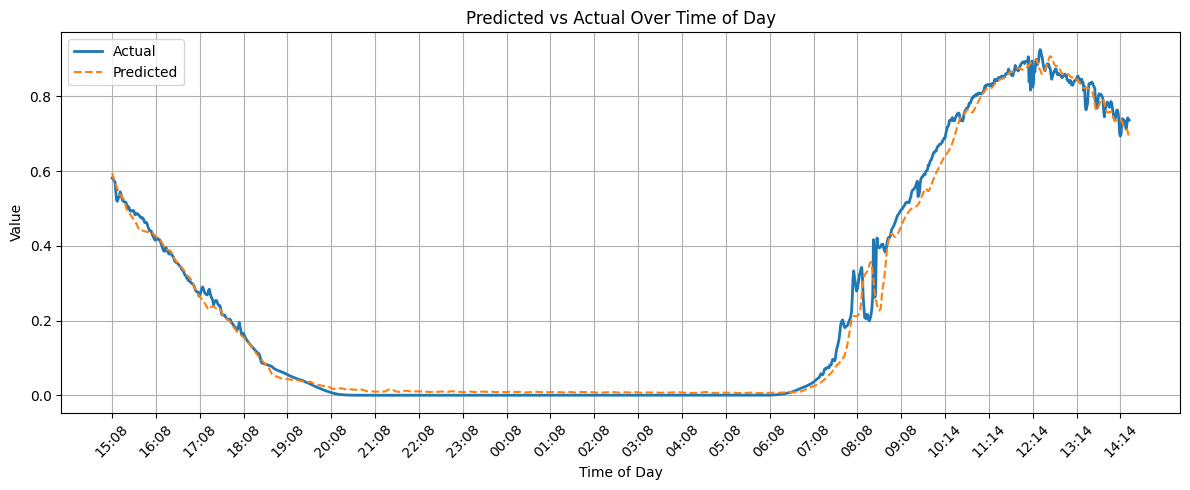

In [93]:
plt.figure(figsize=(12, 5))
plt.plot(time_of_day[:len(y_test)], y_test, label='Actual', linewidth=2)
plt.plot(time_of_day[:len(y_pred)], y_pred, label='Predicted', linestyle='--')
plt.title("Predicted vs Actual Over Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Value")
plt.xticks(time_of_day[::60], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


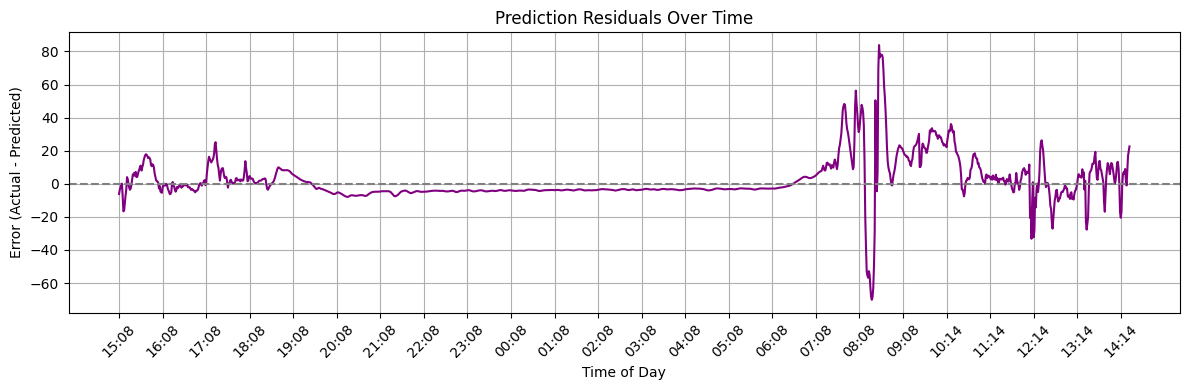

In [94]:
residuals = y_test_unscaled - y_pred_unscaled

plt.figure(figsize=(12, 4))
plt.plot(time_of_day[:len(residuals)], residuals, label="Residuals", color='purple')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Prediction Residuals Over Time")
plt.xlabel("Time of Day")
plt.ylabel("Error (Actual - Predicted)")
plt.xticks(time_of_day[::60], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

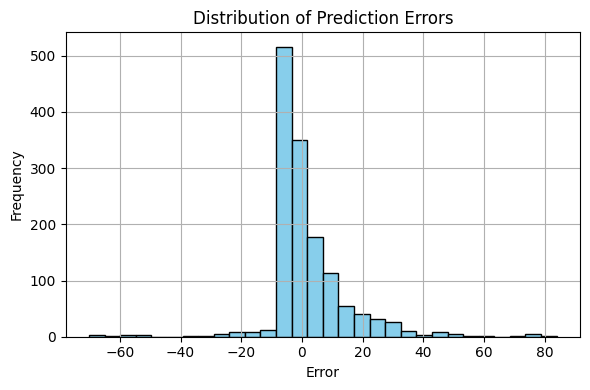

In [95]:
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

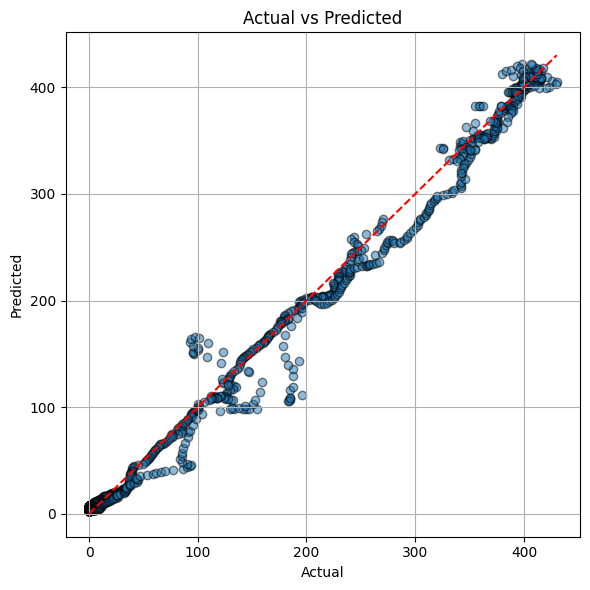

In [96]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_unscaled, y_pred_unscaled, alpha=0.5, edgecolors='k')
plt.plot([min(y_test_unscaled), max(y_test_unscaled)], [min(y_test_unscaled), max(y_test_unscaled)], 'r--')  # perfect prediction line
plt.title("Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()